In [5]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 1.4 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"H {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='A', spin=0, verbose=4)
mol.build()

mf = scf.RHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Fri Jan 23 20:12:26 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = A
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr  

np.float64(-0.07441915795140226)

In [6]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'hf/cisd',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 2
# Number of Cholesky vectors: 3
#


/home/sharmagroup/sharmagroup/cs_afqmc/ad_afqmc/pyscf_interface.py:567: RuntimeWarning: divide by zero encountered in divide
  chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5
/home/sharmagroup/sharmagroup/cs_afqmc/ad_afqmc/pyscf_interface.py:567: RuntimeWarning: invalid value encountered in divide
  chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5


In [7]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config, stat_utils
from ad_afqmc.prop_unrestricted import prop_unrestricted, sampling
import time

In [8]:
# RHF_CISD 2
ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
olp, e1, e2 = trial.calc_energy_mixed(
    prop_data['walkers'], ham_data, wave_data)
e1_init = jnp.array(jnp.sum(e1) / prop.n_walkers)
e2_init = jnp.array(jnp.sum(e2) / prop.n_walkers)
prop_data["e_estimate"] = e1
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t weight \t weight_p \t Energy_G \t Energy_T \t Walltime")
    print(f"  {0:5d} \t {e1_init:.6f} \t {e2_init:.6f} \t "
          f"  {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler_mixed(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
e2_eq_sp = np.empty(options['n_eql'])

for n in range(1,options["n_eql"]+1):
    prop_data, (wt, wp, e1, e2) =\
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    e2_eq_sp[i] = e2
    print(f"  {n:5d} \t {wt:.6f} \t {wp:.6f} \t {e1:.6f} \t {e2:.6f}")

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 2
# nelec: (1, 1)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: rhf
# trial: hf/cisd
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Propagating with 50 walkers
# Equilibration sweeps:
#   Iter 	 weight 	 weight_p 	 Energy_G 	 Energy_T 	 Walltime
      0 	 -1.023569 	 -0.949150 	   1.18
      1 	 2499.829490 	 2279.003901 	 -1.359483 	 -1.103759
      2 	 2499.585727 	 2236.914813 	 -1.447633 	 -1.134204
      3 	 2499.478010 	 2276.061893 	 -1.384995 	 -1.103888


In [40]:
nsamples = 50
eci2_sp_list = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, wp, ehf, eci)  =\
        sampler.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    eci2_sp_list[i] = eci
    print(f"  {n:5d} \t {ehf:.6f} \t {eci:.6f} \t {time.time() - init_time:.2f}")

      1 	 -108.617202 	 -108.660384 	 84.01
      2 	 -108.707364 	 -108.671170 	 84.16
      3 	 -108.645582 	 -108.652638 	 84.32
      4 	 -108.721286 	 -108.672148 	 84.47
      5 	 -108.730875 	 -108.669527 	 84.63
      6 	 -108.659291 	 -108.655721 	 84.78
      7 	 -108.608246 	 -108.663520 	 84.93
      8 	 -108.671459 	 -108.684720 	 85.09
      9 	 -108.655779 	 -108.656273 	 85.24
     10 	 -108.687008 	 -108.660484 	 85.39
     11 	 -108.618866 	 -108.657747 	 85.55
     12 	 -108.738019 	 -108.683565 	 85.70
     13 	 -108.621070 	 -108.660032 	 85.86
     14 	 -108.598735 	 -108.661495 	 86.01
     15 	 -108.572557 	 -108.657573 	 86.17
     16 	 -108.699098 	 -108.671038 	 86.32
     17 	 -108.732768 	 -108.676607 	 86.48
     18 	 -108.641604 	 -108.664138 	 86.63
     19 	 -108.664671 	 -108.660294 	 86.79
     20 	 -108.601384 	 -108.652694 	 86.94
     21 	 -108.654949 	 -108.659887 	 87.09
     22 	 -108.553092 	 -108.654770 	 87.25
     23 	 -108.660344 	 -108.651

In [9]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 2
# Number of Cholesky vectors: 3
#


In [10]:
ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
e1 = trial.calc_energy(
    prop_data['walkers'], ham_data, wave_data)
e1 = jnp.array(jnp.sum(e1) / prop.n_walkers)

prop_data["e_estimate"] = e1
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t weight\t Energy \t Walltime")
    print(f"  {0:5d} \t {e1_init:.6f} \t "
          f"  {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
for n in range(1,options["n_eql"]+1):
    prop_data, (wt, e1) =\
        sampler_eq.propagate_phaseless(ham, ham_data, prop, prop_data, trial, wave_data)

    print(f"  {n:5d} \t {wt:.6f} \t {wp:.6f} \t {e1:.6f} \t {e2:.6f}")

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 2
# nelec: (1, 1)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: rhf
# trial: cisd
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Propagating with 50 walkers
# Equilibration sweeps:
#   Iter 	 weight	 Energy 	 Walltime
      0 	 -1.023569 	   0.98
      1 	 2499.831798 	 2276.061893 	 -1.023569+0.000000j 	 -1.103888
      2 	 2499.588700 	 2276.061893 	 -1.023569+0.000000j 	 -1.103888
      3 	 2499.480541 	 2276.061893 	 -1.023569+0.000000j 	 -1.103888


In [13]:
from ad_afqmc.prop_unrestricted import wavefunctions_restricted
trial_mixed = wavefunctions_restricted.rhf_cisd(trial.norb, trial.nelec, n_batch=options["n_batch"])
sampler_eq = sampling.sampler_mixed(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
e2_eq_sp = np.empty(options['n_eql'])

for n in range(1,options["n_eql"]+1):
    prop_data, (wt, wp, e1, e2) =\
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial_mixed, wave_data)
    e2_eq_sp[i] = e2
    print(f"  {n:5d} \t {wt:.6f} \t {wp:.6f} \t {e1:.6f} \t {e2:.6f}")

      1 	 2499.663075 	 2264.516839 	 -1.415490+0.000000j 	 -1.115311
      2 	 2499.390375 	 2253.503880 	 -1.392340+0.000000j 	 -1.122391
      3 	 2499.523467 	 2238.077318 	 -1.432918+0.000000j 	 -1.132307


In [14]:
olp,e1,e2 = trial_mixed.calc_energy_mixed(prop_data["walkers"],ham_data,wave_data)

In [15]:
print(e1)

[-1.12803468 -1.02244778 -1.03167843 -1.02813836 -1.28341835 -1.0913688
 -1.05888013 -1.09409199 -2.79890134 -1.23303698 -1.20542725 -1.02468168
 -1.08231031 -1.30369817 -1.72205956 -1.2239486  -1.04233954 -1.50484874
 -1.02555148 -1.15435712 -1.046708   -1.04474937 -1.62198681 -1.09879778
 -1.55740076 -1.27628359 -2.60840138 -1.0687894  -1.14709488 -1.0233039
 -1.02442823 -1.06264332 -2.2185246  -1.03801806 -1.06469237 -1.58541062
 -3.39439222 -1.03037718 -1.03118763 -1.08474777 -2.67480883 -1.03843113
 -1.26291589 -1.41074991 -1.32102543 -1.00992692 -1.13325937 -1.0985436
 -1.10587392 -1.3221135 ]


AFQMC/RHF average = -108.64442197378378, std = 0.007651702438041908
AFQMC/CISD_RHF method1 average = -108.66301607820961, std = 0.0017832873081116128
AFQMC/CISD_RHF method2 average = -108.6602033857966, std = 0.0011271986772199327


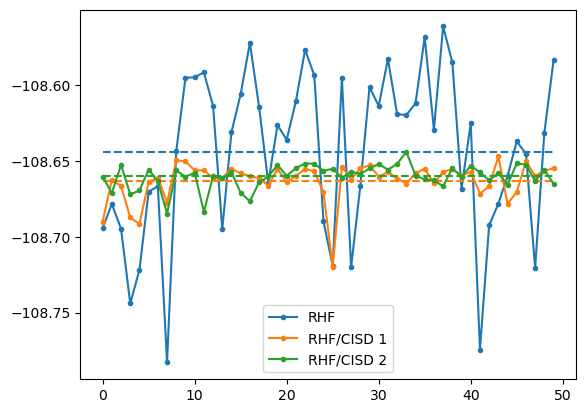

In [41]:
from matplotlib import pyplot as plt
ehf_avg = ehf_sp_list.mean()
ehf_avg_std = np.std(ehf_sp_list, ddof=1) / np.sqrt(len(ehf_sp_list))
eci_avg = eci_sp_list.mean()
eci_avg_std = np.std(eci_sp_list, ddof=1) / np.sqrt(len(eci_sp_list))
eci2_avg = eci2_sp_list.mean()
eci2_avg_std = np.std(eci2_sp_list, ddof=1) / np.sqrt(len(eci2_sp_list))
print(f'AFQMC/RHF average = {ehf_avg}, std = {ehf_avg_std}')
print(f'AFQMC/CISD_RHF method1 average = {eci_avg}, std = {eci_avg_std}')
print(f'AFQMC/CISD_RHF method2 average = {eci2_avg}, std = {eci2_avg_std}')
plt.plot(ehf_sp_list,'.-',label='RHF',color='C0')
plt.plot([ehf_avg]*len(ehf_sp_list),'--',color='C0')
plt.plot(eci_sp_list,'.-',label='RHF/CISD 1',color='C1')
plt.plot([eci_avg]*len(eci_sp_list),'--',color='C1')
plt.plot(eci2_sp_list,'.-',label='RHF/CISD 2',color='C2')
plt.plot([eci2_avg]*len(eci2_sp_list),'--',color='C2')
plt.legend()
plt.show()

In [44]:
# CISD
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
h0 = ham_data['h0']

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    e_init = prop_data["e_estimate"]
    print('# \n')
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t energy \t Walltime")
    print(f"  {0:5d} \t {e_init:.6f} \t {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
ecisd_eq_list = np.empty(options['n_eql'])

for i,n in enumerate(range(1,options["n_eql"]+1)):
    prop_data, (wt, ecisd) = sampler_eq.propagate_phaseless(
        ham, ham_data, prop, prop_data, trial, wave_data)
    ecisd_eq_list[i] = ecisd
    print(f"  {n:5d} \t {ecisd:.6f} \t {time.time() - init_time:.2f}")

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Using GPU.
# System: Linux
# Node Name: sharmagroup-rn
# Release: 6.14.0-37-generic
# Version: #37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2
# Machine: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: rhf
# trial: cisd
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# 

# Propagating with 50 walkers
# Equilibration sweeps:
#   Iter 	 energy 	 Walltime
      0 	 -108.664417 	 0.99
      1 	 -108.677497 	 3.24
      2 	 -108.674546 	 5.50
      3 	 -108.674698 	 7.76


In [46]:
nsamples = 50
ecisd_sp_list = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, ecisd)  =\
        sampler.propagate_phaseless(
            ham, ham_data, prop, prop_data, trial, wave_data)
    ecisd_sp_list[i] = ecisd
    print(f"  {n:5d} \t {ecisd:.6f} \t {time.time() - init_time:.2f}")

      1 	 -108.661505 	 74.53
      2 	 -108.662179 	 74.76
      3 	 -108.645008 	 74.98
      4 	 -108.664543 	 75.21
      5 	 -108.699117 	 75.44
      6 	 -108.678690 	 75.66
      7 	 -108.678274 	 75.89
      8 	 -108.680250 	 76.12
      9 	 -108.666034 	 76.34
     10 	 -108.695417 	 76.57
     11 	 -108.666232 	 76.80
     12 	 -108.690531 	 77.02
     13 	 -108.667413 	 77.25
     14 	 -108.666849 	 77.48
     15 	 -108.674402 	 77.70
     16 	 -108.703675 	 77.93
     17 	 -108.676118 	 78.16
     18 	 -108.665097 	 78.39
     19 	 -108.672626 	 78.61
     20 	 -108.665364 	 78.84
     21 	 -108.669866 	 79.07
     22 	 -108.660671 	 79.29
     23 	 -108.676191 	 79.52
     24 	 -108.659958 	 79.75
     25 	 -108.670890 	 79.97
     26 	 -108.662316 	 80.20
     27 	 -108.669310 	 80.43
     28 	 -108.657110 	 80.65
     29 	 -108.666222 	 80.88
     30 	 -108.662778 	 81.11
     31 	 -108.673506 	 81.33
     32 	 -108.667330 	 81.56
     33 	 -108.668414 	 81.79
     34 	 

AFQMC/RHF average = -108.64442197378378, std = 0.007651702438041908
AFQMC/CISD_RHF method1 average = -108.66301607820961, std = 0.0017832873081116128
AFQMC/CISD_RHF method2 average = -108.6602033857966, std = 0.0011271986772199327
AFQMC/CISD Original method2 average = -108.67064547250601, std = 0.001602460434440548


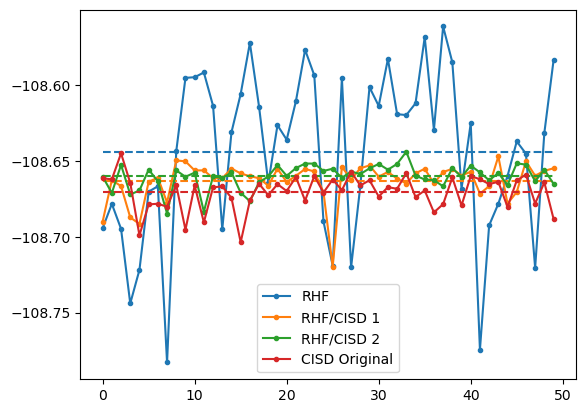

In [47]:
from matplotlib import pyplot as plt
ehf_avg = ehf_sp_list.mean()
ehf_avg_std = np.std(ehf_sp_list, ddof=1) / np.sqrt(len(ehf_sp_list))
eci_avg = eci_sp_list.mean()
eci_avg_std = np.std(eci_sp_list, ddof=1) / np.sqrt(len(eci_sp_list))
eci2_avg = eci2_sp_list.mean()
eci2_avg_std = np.std(eci2_sp_list, ddof=1) / np.sqrt(len(eci2_sp_list))
ecisd_avg = ecisd_sp_list.mean()
ecisd_avg_std = np.std(ecisd_sp_list, ddof=1) / np.sqrt(len(ecisd_sp_list))
print(f'AFQMC/RHF average = {ehf_avg}, std = {ehf_avg_std}')
print(f'AFQMC/CISD_RHF method1 average = {eci_avg}, std = {eci_avg_std}')
print(f'AFQMC/CISD_RHF method2 average = {eci2_avg}, std = {eci2_avg_std}')
print(f'AFQMC/CISD Original method2 average = {ecisd_avg}, std = {ecisd_avg_std}')
plt.plot(ehf_sp_list,'.-',label='RHF',color='C0')
plt.plot([ehf_avg]*len(ehf_sp_list),'--',color='C0')
plt.plot(eci_sp_list,'.-',label='RHF/CISD 1',color='C1')
plt.plot([eci_avg]*len(eci_sp_list),'--',color='C1')
plt.plot(eci2_sp_list,'.-',label='RHF/CISD 2',color='C2')
plt.plot([eci2_avg]*len(eci2_sp_list),'--',color='C2')
plt.plot(ecisd_sp_list,'.-',label='CISD Original',color='C3')
plt.plot([ecisd_avg]*len(ecisd_sp_list),'--',color='C3')
plt.legend()
plt.show()